In [1]:
import pandas as pd   #data_frame
import numpy as np   #数值计算
import xgboost as xgb
from sklearn.model_selection import train_test_split   #机器学习，split：分test和train
import matplotlib.pyplot as plt  #画图

%matplotlib inline  
plt.style.use('ggplot')

In [3]:
df = pd.read_csv('/Users/wangweiqi/Desktop/Titanic.csv')

In [5]:
df.head(10) #默认5行

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [6]:
def proc(str1):
    res = str1.split(',')[1].split('.')[0].strip()
    if res in ['Mr', 'Miss', 'Mrs', 'Master']:
        return res
    else:
        return 'Others'

df['Title']=df['Name'].astype(str).apply(proc)

In [1]:
df

NameError: name 'df' is not defined

In [7]:
df['HasCabin']=df['Cabin'].apply(pd.isnull) #判断变量是否为空，变为bool型变量

In [8]:
df['Sex'].value_counts()  #数值分布

male      577
female    314
Name: Sex, dtype: int64

In [9]:
df['Title'].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Others     27
Name: Title, dtype: int64

In [10]:
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [11]:
for t in ['Sex', 'Title', 'Embarked']:
    df = pd.concat([df, pd.get_dummies(df[t])], axis=1)  #转换成one hot变量

In [12]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,female,male,Master,Miss,Mr,Mrs,Others,C,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,1,0,0,1,0,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,0,0,0,0,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,1,0,0,1,0,0,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,1,0,0,0,0,1,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,1,0,0,1,0,0,0,0,1


In [13]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'HasCabin',
       'female', 'male', 'Master', 'Miss', 'Mr', 'Mrs', 'Others', 'C', 'Q',
       'S'],
      dtype='object')

In [21]:
feats = [t for t in df.columns
         if t not in ['Survived', 'Name', 'Ticket', 'Cabin', 'Sex', 'Title', 'Embarked', 'PassengerId']]
target = ['Survived']

In [23]:
df_train, df_test = train_test_split(df, stratify=df['Survived'], test_size=0.2, random_state=42)

In [24]:
df_train.shape,df_test.shape  #训练集有多少个，test集有多少个

((712, 24), (179, 24))

In [25]:
data_trn = xgb.DMatrix(df_train[feats], label=df_train[target]) #转换成xgboost接受的格式
data_val = xgb.DMatrix(df_test[feats], label=df_test[target])

In [26]:
param = {
    'silent': 1,
    'eta': 0.08, #学习速率，迭代速度
    'gamma': 0,  #
    'max_depth ': 2,  #最大深度，设的越大拟合越好，但有可能过拟合
    'min_child_weight': 1, #子节点的最小权重，控制叶子节点的数量
    'subsample': 1,  #选取切分点
    'lambda': 1,
    'alpha': 0,
    'bjective': 'binary:logistic',  #优化目标
    'eval_metric': 'logloss',
} #控制单棵树，

In [27]:
evals_result = {}
bst = xgb.train(
    params=param, # Booster params
    dtrain=data_trn, # Data to be trained
    num_boost_round=200, #  Number of boosting iterations 最多迭代多少轮
    evals=[(data_trn, 'train'), (data_val, 'eval')], # 模型在train集和test集的表现，List of items to be evaluated during training, this allows user to watch performance on the validation set
    obj=None, # Customized objective function
    feval=None, # Customized evaluation function
    maximize=False, # Whether to maximize feval
    early_stopping_rounds=3, #如果在3轮之内模型在测试集的效果没有得到提升，就停止训练 Validation error needs to decrease at least every <early_stopping_rounds> round(s) to continue training
    evals_result=evals_result, # This dictionary stores the evaluation results of all the items in watchlist
    verbose_eval=2,
    learning_rates=None, # List of learning rate for each boosting round
    xgb_model=None,
    callbacks=None, # list of callback functions
)  #logloss越小越好，

[0]	train-logloss:0.644084	eval-logloss:0.655657
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 3 rounds.
[2]	train-logloss:0.563202	eval-logloss:0.597299
[4]	train-logloss:0.500736	eval-logloss:0.558651
[6]	train-logloss:0.449635	eval-logloss:0.529011
[8]	train-logloss:0.407089	eval-logloss:0.507065
[10]	train-logloss:0.37451	eval-logloss:0.492354
[12]	train-logloss:0.344772	eval-logloss:0.481165
[14]	train-logloss:0.320689	eval-logloss:0.471064
[16]	train-logloss:0.298508	eval-logloss:0.462935
[18]	train-logloss:0.280579	eval-logloss:0.459645
[20]	train-logloss:0.263187	eval-logloss:0.458922
[22]	train-logloss:0.249087	eval-logloss:0.458764
Stopping. Best iteration:
[19]	train-logloss:0.271463	eval-logloss:0.458588



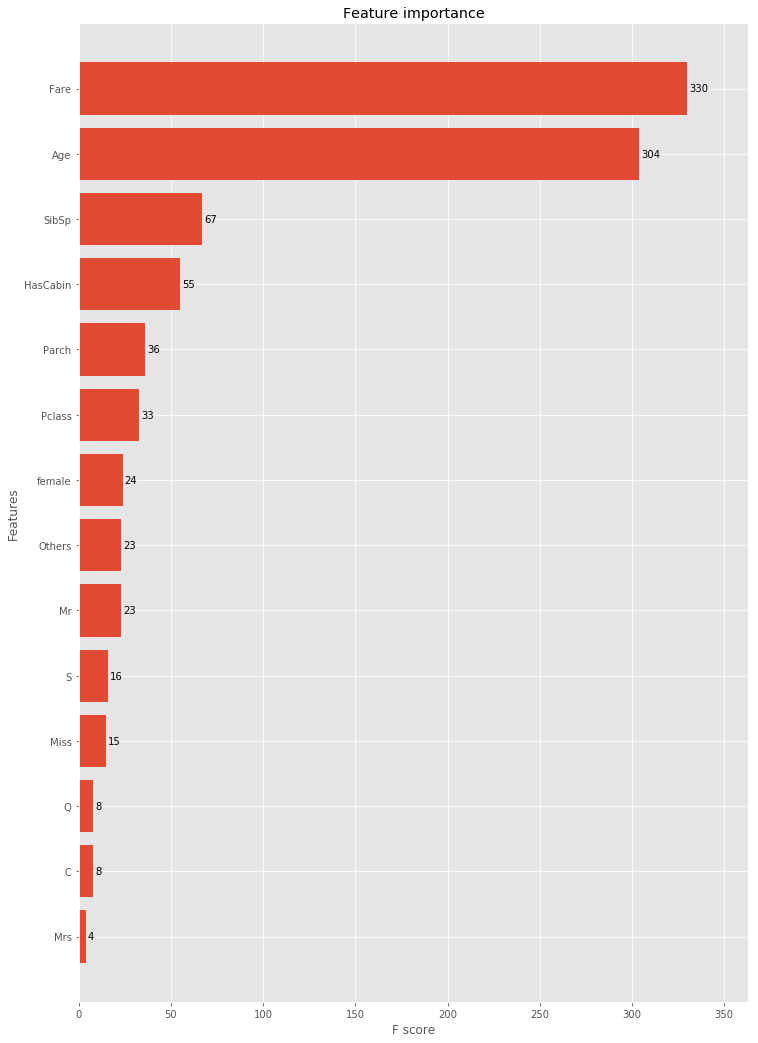

In [28]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(bst, max_num_features=50, height=0.8, ax=ax, importance_type='weight')
plt.show()

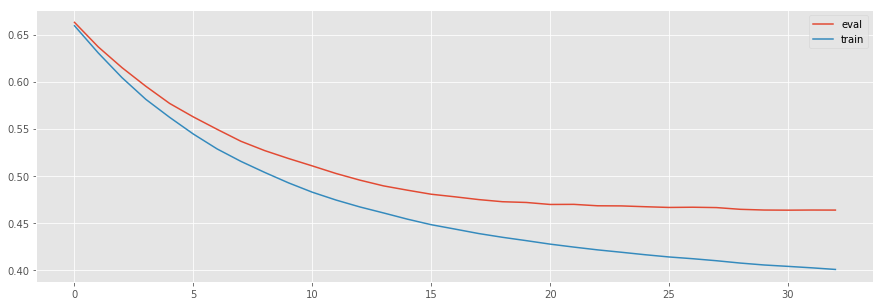

In [57]:
pd.DataFrame({'eval': evals_result['eval']['logloss'], 'train': evals_result['train']['logloss']}).plot(figsize=(15,5))